<a href="https://colab.research.google.com/github/zaeyonglee/KHUDA_DATATON_202510/blob/main/Data_preprocessing/Nutritional_Analysis%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Columns in df_standard: Index(['시도교육청코드', '시도교육청명', '행정표준코드', '학교명', '식사코드', '식사명', '급식일자', '급식인원수',
       '요리명', '원산지정보', '칼로리정보', '영양정보', '수정일자'],
      dtype='object')
그래프가 'nutritional_balance_excluding_kindergarten.png'로 저장되었습니다.


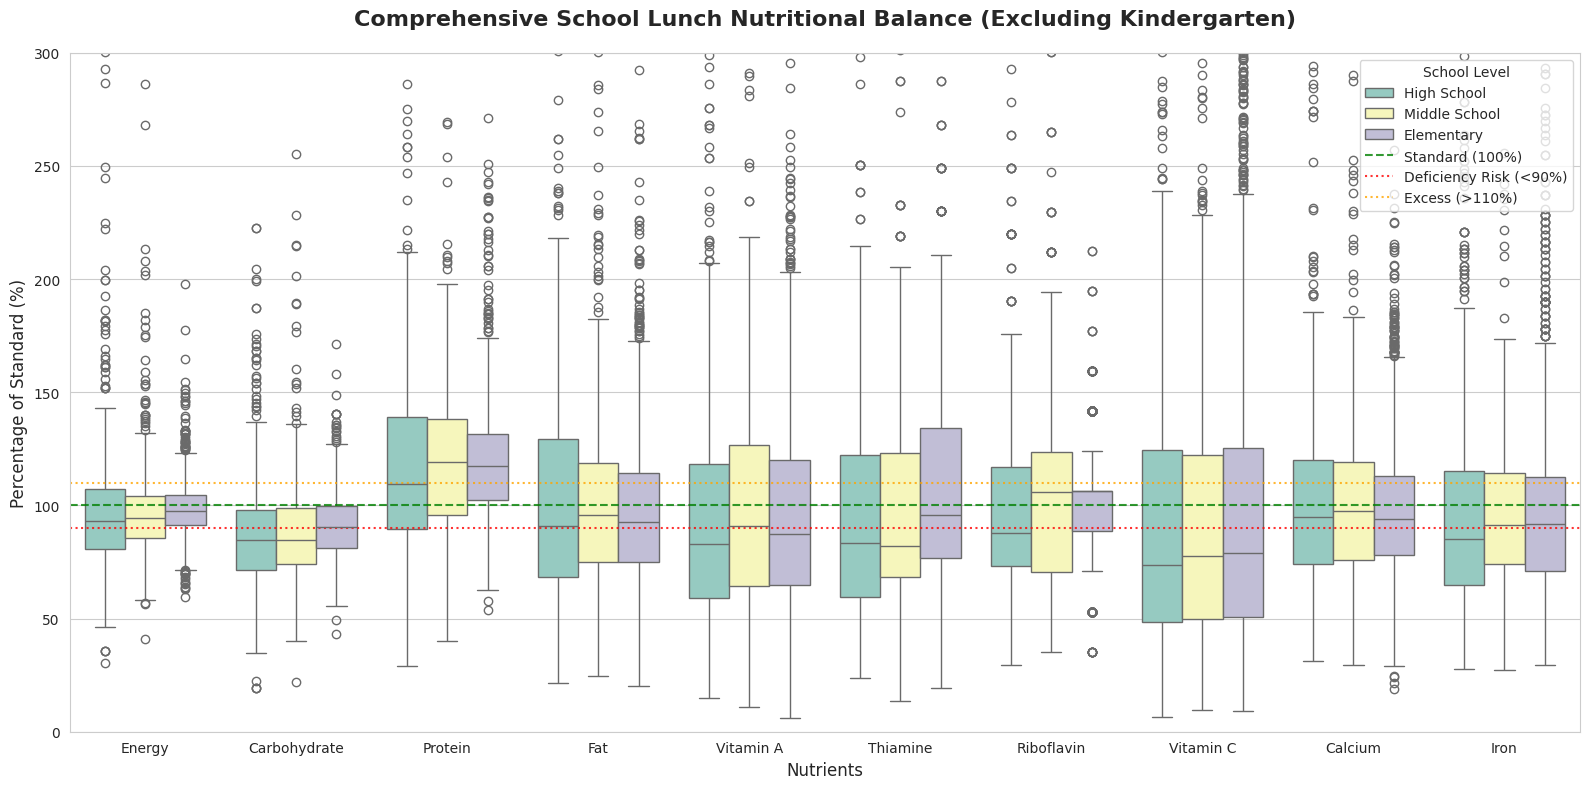

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 데이터 로드 및 기준 설정 (Data Loading & Standard Setup)
# ==========================================

# 파일 경로 (업로드된 원본 파일명 사용)
std_file_path = 'diet.csv'
menu_file_path = 'menu.xls'

# 데이터 읽기
df_standard = pd.read_csv(std_file_path, encoding='utf-8', encoding_errors='replace')
df_menu = pd.read_excel(menu_file_path)

# Diagnose: Print columns to check for '에너지'
print("Columns in df_standard:", df_standard.columns)

# FIX: Extract '에너지' from '칼로리정보' in df_standard
def extract_energy_from_kcal_info(cal_info_str):
    try:
        energy_match = re.search(r'([\d\.]+)\s*Kcal', str(cal_info_str), re.IGNORECASE)
        if energy_match:
            return float(energy_match.group(1))
    except:
        pass
    return None

df_standard['에너지'] = df_standard['칼로리정보'].apply(extract_energy_from_kcal_info)

# [핵심] 학교급식 영양관리기준에 따른 3대 영양소 기준 자동 계산
# 탄수화물(60%), 단백질(15%), 지방(25%) 비율 적용
# 탄수화물, 단백질은 1g당 4kcal, 지방은 1g당 9kcal
df_standard['탄수화물'] = (df_standard['에너지'] * 0.60 / 4).round(1)
df_standard['단백질_계산'] = (df_standard['에너지'] * 0.15 / 4).round(1) # 기존 '단백질' 컬럼 대신 사용
df_standard['지방'] = (df_standard['에너지'] * 0.25 / 9).round(1)

# NEW: Create '학생' column based on '학교명' for grouping
def categorize_student_level(school_name):
    if '유치원' in school_name:
        return None  # Exclude Kindergarten
    elif '초등학교' in school_name:
        return '초등학생'
    elif '중학교' in school_name:
        return '중학생'
    elif '고등학교' in school_name:
        return '고등학생'
    else:
        return None

df_standard['학생'] = df_standard['학교명'].apply(categorize_student_level)
df_standard.dropna(subset=['학생'], inplace=True) # Drop rows where '학생' could not be determined (including Kindergarten)

# NEW: Function to parse micronutrient information from '영양정보' for STANDARDS
def parse_standard_micronutrients(row):
    info = row['영양정보']
    data = {}
    if pd.notna(info):
        items = str(info).replace('<br/>', '\n').split('\n')
        for item in items:
            if ':' in item:
                key, val = item.split(':')
                try:
                    val = float(val.strip())
                    if '비타민A' in key: data['비타민A_권장섭취량'] = val
                    elif '티아민' in key: data['비타민B1_권장섭취량'] = val
                    elif '리보플라빈' in key: data['리보플라빈B2_권장섭취량'] = val
                    elif '비타민C' in key: data['비타민C_권장섭취량'] = val
                    elif '칼슘' in key: data['칼슘_권장섭취량'] = val # Corrected typo
                    elif '철분' in key: data['철_권장섭취량'] = val
                except: continue
    return pd.Series(data)

# Apply this parsing to df_standard to get micronutrient standards
standard_micronutrient_cols = df_standard.apply(parse_standard_micronutrients, axis=1)
df_standard = pd.concat([df_standard, standard_micronutrient_cols], axis=1)

# 학교급별 기준 평균값 산출 (남녀 공통 적용)
std_grouped = df_standard.groupby('학생').mean(numeric_only=True)

# 학교급 매핑 (한글 -> 영어, 그래프 표시용)
school_standards = {}

# 유치원 (Now excluded from df_standard earlier, so this block might not be strictly needed but kept for clarity)
# if '유치원' in std_grouped.index:
#     school_standards['Kindergarten'] = std_grouped.loc['유치원']

# 초등학교 (저학년/고학년 평균)
elem_rows = std_grouped.loc[[i for i in std_grouped.index if '초등' in i]]
if not elem_rows.empty:
    school_standards['Elementary'] = elem_rows.mean()

# 중학교
if '중학생' in std_grouped.index:
    school_standards['Middle School'] = std_grouped.loc['중학생']

# 고등학교
if '고등학생' in std_grouped.index:
    school_standards['High School'] = std_grouped.loc['고등학생']

df_std_final = pd.DataFrame(school_standards).T


# ==========================================
# 2. 식단 데이터 처리 (Menu Data Processing)
# ==========================================

# 중식만 필터링
df_lunch = df_menu[df_menu['식사명'] == '중식'].copy()

# 학교명에서 학교급 추출 함수
def get_school_level_eng(name):
    if '초등학교' in name: return 'Elementary'
    elif '중학교' in name: return 'Middle School'
    elif '고등학교' in name: return 'High School'
    elif '유치원' in name: return None # Exclude Kindergarten
    else: return None

df_lunch['school_level'] = df_lunch['학교명'].apply(get_school_level_eng)
df_lunch = df_lunch.dropna(subset=['school_level']) # Drop rows where 'school_level' is None (including Kindergarten)

# 영양정보 텍스트 파싱 함수
def parse_nutrition(row):
    info = row['영양정보']
    cal_info = row['칼로리정보']
    data = {}

    # 에너지(Kcal) 추출
    try:
        energy_match = re.search(r'([\d\.]+)\s*Kcal', str(cal_info), re.IGNORECASE)
        if energy_match:
            data['Energy'] = float(energy_match.group(1))
    except: pass

    # 각 영양소 추출
    if pd.notna(info):
        items = str(info).replace('<br/>', '\n').split('\n')
        for item in items:
            if ':' in item:
                key, val = item.split(':')
                try:
                    val = float(val.strip())
                    if '단백질' in key: data['Protein'] = val
                    elif '비타민A' in key: data['Vitamin A'] = val
                    elif '티아민' in key: data['Thiamine'] = val
                    elif '리보플라빈' in key: data['Riboflavin'] = val
                    elif '비타민C' in key: data['Vitamin C'] = val
                    elif '칼슘' in key: data['Calcium'] = val
                    elif '철분' in key: data['Iron'] = val
                    elif '탄수화물' in key: data['Carbohydrate'] = val
                    elif '지방' in key: data['Fat'] = val
                except: continue
    return pd.Series(data)

# 파싱 적용
nutrient_cols = df_lunch.apply(parse_nutrition, axis=1)
df_lunch = pd.concat([df_lunch, nutrient_cols], axis=1)


# ==========================================
# 3. 달성률 계산 (Calculating Percentages)
# ==========================================

# 메뉴 컬럼(영어)과 기준 파일 컬럼(한글) 매핑
nutrient_map = {
    'Energy': '에너지',
    'Carbohydrate': '탄수화물',   # 자동 계산된 컬럼
    'Protein': '단백질_계산',     # 자동 계산된 컬럼
    'Fat': '지방',               # 자동 계산된 컬럼
    'Vitamin A': '비타민A_권장섭취량',
    'Thiamine': '비타민B1_권장섭취량',
    'Riboflavin': '리보플라빈B2_권장섭취량',
    'Vitamin C': '비타민C_권장섭취량',
    'Calcium': '칼슘_권장섭취량',
    'Iron': '철_권장섭취량'
}

comparison_rows = []
for idx, row in df_lunch.iterrows():
    level = row['school_level']
    if level in df_std_final.index:
        std_row = df_std_final.loc[level]
        res = {'School': row['학교명'], 'Level': level}

        for menu_col, std_col in nutrient_map.items():
            # 데이터가 모두 존재할 경우에만 계산
            if pd.notna(row.get(menu_col)) and pd.notna(std_row.get(std_col)):
                pct = (row[menu_col] / std_row[std_col]) * 100
                res[menu_col] = pct
        comparison_rows.append(res)

df_comparison = pd.DataFrame(comparison_rows)


# ==========================================
# 4. 시각화 (Visualization)
# ==========================================

# 시각화를 위해 데이터 형태 변환 (Wide -> Long)
nutrients_list = list(nutrient_map.keys())
df_melted = df_comparison.melt(id_vars=['Level', 'School'],
                               value_vars=nutrients_list,
                               var_name='Nutrient',
                               value_name='Percentage')

# No need to filter df_melted_filtered as Kindergarten data is already excluded upstream
# df_melted_filtered = df_melted[df_melted['Level'] != 'Kindergarten']

# 그래프 설정
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid") # 깔끔한 배경 스타일

# Boxplot 그리기
sns.boxplot(data=df_melted, x='Nutrient', y='Percentage', hue='Level', palette='Set3') # Use df_melted directly

# 기준선 추가
plt.axhline(100, color='green', linestyle='--', alpha=0.8, linewidth=1.5, label='Standard (100%)')
plt.axhline(90, color='red', linestyle=':', alpha=0.8, linewidth=1.5, label='Deficiency Risk (<90%)')
plt.axhline(110, color='orange', linestyle=':', alpha=0.8, linewidth=1.5, label='Excess (>110%)')

# 제목 및 라벨 설정
plt.title('Comprehensive School Lunch Nutritional Balance (Excluding Kindergarten)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Percentage of Standard (%)', fontsize=12)
plt.xlabel('Nutrients', fontsize=12)
plt.ylim(0, 300) # 이상치로 인한 왜곡 방지를 위해 Y축 범위 제한
plt.legend(loc='upper right', title='School Level', frameon=True)

# 그래프 저장 및 출력
plt.tight_layout()
plt.savefig('nutritional_balance_excluding_kindergarten.png', dpi=300)
print("그래프가 'nutritional_balance_excluding_kindergarten.png'로 저장되었습니다.")
plt.show()